In [ ]:
! pip install gdown
! pip install joblib
! pip install functions-framework==3.0.0
! pip install --upgrade google-cloud-aiplatform

LIBRERÍAS

In [ ]:
# Generales y Manipulación de Datos:
import io
import os
import requests
import json
import pandas as pd
import numpy as np
import math
import joblib
import time

# Google Cloud
import google.cloud.storage as storage

from google.cloud import aiplatform

# Machine Learning
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import sklearn.preprocessing as pp
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

#  Gráficos y Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Correo Electrónico
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Google Colab y Autenticación
from google.colab import auth

CONEXIÓN CON GOOGLE COLAB

In [ ]:
auth.authenticate_user()

# user: vrg1984cloud2@gmail.com

# pass: Bootcamp11

# mismas credenciales para inicio de sesión en Google Cloud Platform

DESCARGA DE DATOS DE DRIVE

In [ ]:
# Descarga de train, test y un conjunto de prueba procesados
! gdown '1LPXawKkR2kOhk-8n-u0tJqnpkxpNddCy'
! gdown '1bOJmOxMsYb8r0lqwx8DsXzQWMXml1jVb'

# Descomprimimos datos
! mkdir ./data && unzip /content/data_los_gatos_1.zip data_los_gatos_1/test_processed.csv data_los_gatos_1/last_10000_rows_proc.csv -d ./data && rm /content/data_los_gatos_1.zip
! unzip /content/data_los_gatos_2.zip train_processed.csv -d ./data && rm /content/data_los_gatos_2.zip

# Creamos carpetas necesarias en Goole Colab
! mkdir model && ! mkdir synchronized_batch

Downloading...
From: https://drive.google.com/uc?id=1LPXawKkR2kOhk-8n-u0tJqnpkxpNddCy
To: /content/data_los_gatos_1.zip
100% 721M/721M [00:13<00:00, 54.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bOJmOxMsYb8r0lqwx8DsXzQWMXml1jVb
To: /content/data_los_gatos_2.zip
100% 314M/314M [00:07<00:00, 43.2MB/s]
Archive:  /content/data_los_gatos_1.zip
  inflating: ./data/data_los_gatos_1/last_10000_rows_proc.csv  
  inflating: ./data/data_los_gatos_1/test_processed.csv  
Archive:  /content/data_los_gatos_2.zip
  inflating: ./data/train_processed.csv  


CREACIÓN DE VARIABLES DE GOOGLE CLOUD


In [ ]:
PROJECT_ID = "tfb11-gatos-2023"

BUCKET_NAME = "bucket-tfb11-gatos-2023"

BUCKET_URI = f"gs://{BUCKET_NAME}"

REGION = "europe-west1"

IMAGE_URI = 'europe-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-2:latest' # fuente : https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers?hl=es-419

CREACIÓN DE PROYECTO

In [ ]:
# Ejecutar solo si no existe, en este caso el proyecto ya está creado
#! gcloud projects create {PROJECT_ID}

# Establecer el proyecto como predeterminado
! gcloud config set project {PROJECT_ID}
! gcloud config list

Updated property [core/project].
[component_manager]
disable_update_check = True
[core]
account = vrg1984cloud2@gmail.com
project = tfb11-gatos-2023

Your active configuration is: [default]


CREACIÓN DE BUCKET

In [ ]:
# Creación de bucket
! gsutil mb -p {PROJECT_ID} -c regional -l {REGION} {BUCKET_URI}

# Listar bucket
! gsutil ls

Creating gs://bucket-tfb11-gatos-2023/...
gs://bucket-tfb11-gatos-2023/


PASAMOS LOS CSV DE LOCAL A NUESTRO BUCKET DE GOOGLE CLOUD

In [ ]:
# Crea un cliente de almacenamiento de Google Cloud
client = storage.Client()

# Nombre del archivo CSV en tu entorno de Colab
archivo_csv_train = './data/train_processed.csv'
archivo_csv_test = './data/data_los_gatos_1/test_processed.csv'
archivo_csv_last = './data/data_los_gatos_1/last_10000_rows_proc.csv'

# Nombre del archivo CSV en Google Cloud Storage (dentro de tu bucket)
nombre_archivo_train = 'data/train_processed.csv'
nombre_archivo_test = 'data/test_processed.csv'
nombre_archivo_last = 'data/batch_sync_processed.csv'

# Sube el archivo CSV de Train y Test y Prueba a tu bucket
bucket = client.get_bucket(BUCKET_NAME)
blob_train = bucket.blob(nombre_archivo_train)
blob_test = bucket.blob(nombre_archivo_test)
blob_last = bucket.blob(nombre_archivo_last)
blob_train.upload_from_filename(archivo_csv_train)
blob_test.upload_from_filename(archivo_csv_test)
blob_last.upload_from_filename(archivo_csv_last)

print(f"El archivo CSV '{nombre_archivo_train}' ha sido subido a '{BUCKET_NAME}'.")
print(f"El archivo CSV '{nombre_archivo_test}' ha sido subido a '{BUCKET_NAME}'.")
print(f"El archivo CSV '{nombre_archivo_last}' ha sido subido a '{BUCKET_NAME}'.")

El archivo CSV 'data/train_processed.csv' ha sido subido a 'bucket-tfb11-gatos-2023'.
El archivo CSV 'data/test_processed.csv' ha sido subido a 'bucket-tfb11-gatos-2023'.
El archivo CSV 'data/batch_sync_processed.csv' ha sido subido a 'bucket-tfb11-gatos-2023'.



UNDERSAMPLING PARA EQUILIBRAR CLASES FRAUDE / NO FRAUDE




In [ ]:
Train = pd.read_csv(f"{BUCKET_URI}/data/train_processed.csv")
Test = pd.read_csv(f"{BUCKET_URI}/data/test_processed.csv")
Batch_sync = pd.read_csv(f"{BUCKET_URI}/data/batch_sync_processed.csv")

In [ ]:
# Vemos cuantas filas tenemos
print("Shape antes de undersamplingen Train:", Train.shape)

# Cargar el conjunto de datos de entrenamiento
X_train = Train.drop('is_fraud', axis=1)
y_train = Train['is_fraud']

# Inicializar el algoritmo de undersampling
rus = RandomUnderSampler(sampling_strategy='auto')
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Shufflear los datos
X_train, y_train = shuffle(X_train_undersampled, y_train_undersampled)

# Unimos los datos
Train = pd.concat([X_train, y_train], axis=1)

print("Shape despues de undersampling en Train:", Train.shape)

# Contar el número de fraudes (etiqueta 1) en y_train
num_frauds_0 = y_train.value_counts()[0]
num_frauds_1 = y_train.value_counts()[1]

# Imprimir el número de fraudes
print("Número de no fraudes en Train:", num_frauds_0)
print("Número de fraudes en Train:", num_frauds_1)

Shape antes de undersamplingen Train: (1481915, 88)
Shape despues de undersampling en Train: (15442, 88)
Número de no fraudes en Train: 7721
Número de fraudes en Train: 7721


NORMALIZAMOS VARIABLES NUMÉRICAS

In [ ]:
X_train = Train.drop(['is_fraud'], axis = 1)
y_train = Train['is_fraud']

# Split X_train into normalizing variables and not-normalizing

variables_tonorm = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'Year', 'Month', 'Unemployed percent',
                   'close_s&p_500','change_usd_eur','crime_rate', 'age', 'week_number','day_of_week','day', 'hour', 'merch_home_distance']

X_train_tonorm = X_train[variables_tonorm]
X_train_notnorm = X_train.drop(variables_tonorm, axis = 1)

# Normalize
scaler_X = StandardScaler().fit(X_train_tonorm)
X_train_normalized = scaler_X.transform(X_train_tonorm)

# Join all variables together:
X_train_notnorm = X_train_notnorm.values
X_train = np.concatenate([X_train_normalized, X_train_notnorm], axis = 1)

# Same steps, USING **TRAIN SCALER**
X_test = Test.drop(['is_fraud'], axis = 1)
y_test = Test['is_fraud']

X_test_tonorm = X_test[variables_tonorm]
X_test_notnorm = X_test.drop(variables_tonorm, axis = 1)

X_test_normalized = scaler_X.transform(X_test_tonorm)

X_test_notnorm = X_test_notnorm.values
X_test = np.concatenate([X_test_normalized, X_test_notnorm], axis = 1)

# Batch
X_batch_tonorm = Batch_sync[variables_tonorm]
X_batch_notnorm = Batch_sync.drop(variables_tonorm, axis = 1)

X_batch_normalized = scaler_X.transform(X_batch_tonorm)

X_batch_notnorm = X_batch_notnorm.values
X_batch = np.concatenate([X_batch_normalized, X_batch_notnorm], axis = 1)

ENTRENAMOS EL MODELO Y LO GUARDAMOS EN NUESTRO BUCKET DE GOOGLE CLOUD

In [ ]:
# Hiperparámetros
maxDepthOptimo = 14
minSamplesLeafOptimo = 4
minSamplesSplitOptimo = 2

# Entrenamos el modelo DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=maxDepthOptimo, min_samples_leaf=minSamplesLeafOptimo,
                               min_samples_split= minSamplesSplitOptimo,
                               class_weight='balanced').fit(X_train,y_train)

# Guarda el modelo en un archivo en colab
model_file = './model/model.joblib'
joblib.dump(model, model_file)

# Guradamos el modelo en el bucket
client = storage.Client()

bucket = client.get_bucket(BUCKET_NAME)
blob = bucket.blob('model/model.joblib')

with open(model_file, 'rb') as f:
    blob.upload_from_file(f)

PREDICCIONES

In [ ]:
# La predicción no afecta al modelo previamente guardado
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]
TN = cm[0, 0]

print("Accuracy del modelo DecisionTree escogido:", accuracy)
print("Precisión del modelo DecisionTree escogido:", precision)
print("Recall del modelo DecisionTree escogido:", recall)
print("F1-Score del modelo DecisionTree escogido:", f1)
print("-----")
print("Verdaderos Positivos DecisionTree:", TP)
print("Falsos Negativos DecisionTree:", FN)
print("Falsos Positivos DecisionTree:", FP)
print("Verdaderos Negativos DecisionTree:", TN)

Accuracy del modelo DecisionTree escogido: 0.970891737453405
Precisión del modelo DecisionTree escogido: 0.1482599713967901
Recall del modelo DecisionTree escogido: 0.966839378238342
F1-Score del modelo DecisionTree escogido: 0.2570956186277211
-----
Verdaderos Positivos DecisionTree: 1866
Falsos Negativos DecisionTree: 64
Falsos Positivos DecisionTree: 10720
Verdaderos Negativos DecisionTree: 357829


FUNCIÓN PARA REPRESENTAR MÉTRICAS

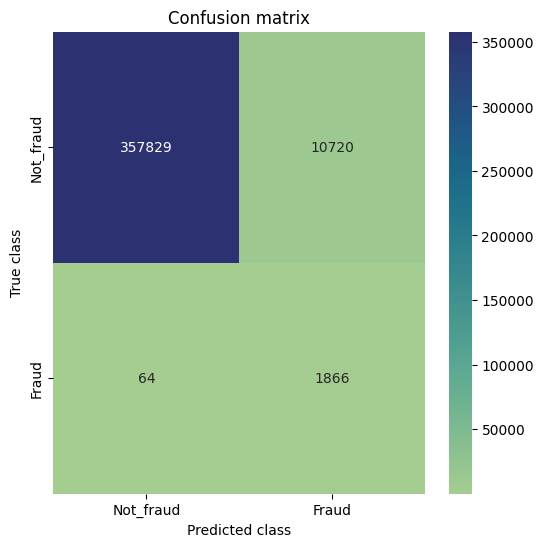


              precision    recall  f1-score   support

           0       1.00      0.97      0.99    368549
           1       0.15      0.97      0.26      1930

    accuracy                           0.97    370479
   macro avg       0.57      0.97      0.62    370479
weighted avg       1.00      0.97      0.98    370479



In [ ]:
LABELS= ['Not_fraud','Fraud']
def results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, cmap="crest", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print()
    print (classification_report(y_test, pred_y))

results(y_test, y_pred)


FEATURES DEL MODELO DECISION TREE CLASSIFIER

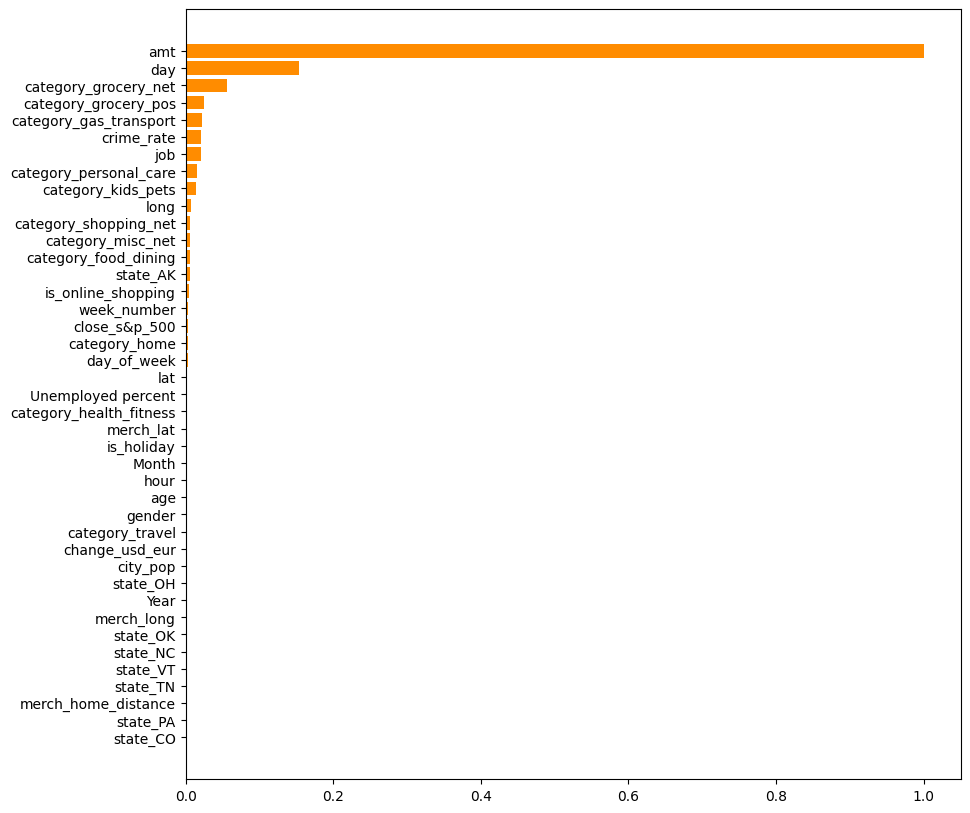

In [ ]:
column_to_move = Train.pop("is_fraud")
Train.insert(0, 'is_fraud', column_to_move)

feature_names_dt = Train.columns[1:]

importances = model.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::1]

# We have seen many zero values, there is no interest in showing these, we filter them:
non_zero_importances = importances[indices][importances[indices] > 0.00]
non_zero_indices = indices[importances[indices] > 0.00]

plt.figure(figsize=(10, 10))
plt.barh(range(len(non_zero_indices)), non_zero_importances, color = 'darkorange')
plt.yticks(range(len(non_zero_indices)), feature_names_dt[non_zero_indices])
plt.show()

REGISTRO DE MODELO


In [ ]:
# Registra modelo
aiplatform.init(project=PROJECT_ID, location=REGION)

model=aiplatform.Model.upload(
    display_name="model",
    artifact_uri=f"{BUCKET_URI}/model/",
    serving_container_image_uri=IMAGE_URI)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/745679309994/locations/europe-west1/models/6703810355480494080/operations/3079831575202889728
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/745679309994/locations/europe-west1/models/6703810355480494080@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/745679309994/locations/europe-west1/models/6703810355480494080@1')


CREACIÓN DE ENDPOINT

In [ ]:
# Obtenemos el id del modelo registrado
MODEL = model.name

# Creamos endpoint
model=aiplatform.Model(f"projects/{PROJECT_ID}/locations/{REGION}/models/{MODEL}")

endpoint = model.deploy(
    deployed_model_display_name="my_endpoint",
    traffic_split={'0': 100},
    machine_type='n1-standard-4',
    accelerator_count=0,
    min_replica_count=1,
    max_replica_count=2)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/745679309994/locations/europe-west1/endpoints/5208017144867979264/operations/4241760279064477696
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/745679309994/locations/europe-west1/endpoints/5208017144867979264
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/745679309994/locations/europe-west1/endpoints/5208017144867979264')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/745679309994/locations/europe-west1/endpoints/5208017144867979264
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/745679309994/locations/europe-west1/endpoints/5208017144867979264/operations/1658382942814076928
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/745679

PREDICCIÓN EN LÍNEA, CON ALGUNAS TRANSACCIONES DE LAS OBTENIDAS DEL FICHERO DE LAS 10000 TRANSACCIONES

In [ ]:
# Cogemos una fila aleatoria de batch y convertido en una lista
selected_row = pd.read_csv(f"{BUCKET_URI}/data/batch_sync_processed.csv").sample(n=1).values.tolist()

In [ ]:
# Configuramos gmail para alerta en caso de transacción fraudulenta

def send_fraud_alert():
    # Configura el servidor SMTP de Gmail
    smtp_server = 'smtp.gmail.com'
    smtp_port = 587

    # Inicia la conexión SMTP
    server = smtplib.SMTP(smtp_server, smtp_port)
    server.starttls()

    # Inicia sesión en tu cuenta de Gmail
    server.login('mesut.jgv@gmail.com', 'bmmx qegn qihv rzpv')

    recipient_emails = ['tfb.bigdata11@gmail.com']

    # Crea un mensaje de correo
    msg = MIMEMultipart()
    msg['From'] = 'mesut.jgv@gmail.com'
    msg['To'] = ','.join(recipient_emails)
    msg['Subject'] = 'Alerta de fraude: posible caso de fraude'

    # Agrega el cuerpo del correo
    msg.attach(MIMEText('Se ha detectado un posible caso de fraude.', 'plain'))

    # Envía el correo electrónico
    now = time.gmtime()
    msg['Date'] = time.strftime('%a, %d %b %Y %H:%M:%S %Z', now)
    server.sendmail('mesut.jgv@gmail.com', recipient_emails, msg.as_string())

    # Cierra la conexión SMTP
    server.quit()

In [ ]:
# Obtenemos el id del endpoint
ENDPOINT = endpoint.name

# Predicción en línea
endpoint = aiplatform.Endpoint(
    endpoint_name=(f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{ENDPOINT}")
)

# Realiza la predicción.
predictions = endpoint.predict(instances=selected_row).predictions
print(predictions)

# Encuentra el elemento más grande de la lista.
max_prediction = max(predictions)

# "No Fraud" si el elemento más grande de la lista es menor que 0.5
if max_prediction < 0.5:
    print("\nNo Fraud")
else:
    print("\nFraud")
    send_fraud_alert()

[0.0]

No Fraud


PREDICCIÓN POR BATCH

NOTA: Aquí no podemos usar esas transacciones del fichero de extracción de 10000 filas porque con esta función se calculan métricas que no podemos tener ya que no sabemos el *ground_truth*

In [ ]:
# Leemos de test las primeras 1000 filas
Batch = pd.read_csv(f"{BUCKET_URI}/data/test_processed.csv").drop("is_fraud", axis=1).head(1000)

# Guardamos Batch a un nuevo CSV para poder usarlo en batch predicción
Batch.to_csv("data/batch_processed.csv", index=False)

# Guardamos en el bucket
blob = bucket.blob("data/batch_processed.csv")
blob.upload_from_filename("data/batch_processed.csv")

In [ ]:
# Obtenemos el id del modelo
MODEL = model.name

# Predicción en línea
model = aiplatform.Model(f"projects/{PROJECT_ID}/locations/{REGION}/models/{MODEL}")

batch_prediction_job = model.batch_predict(
    job_display_name='batch_predict',
    gcs_source=f"{BUCKET_URI}/data/batch_processed.csv",
    gcs_destination_prefix=f"{BUCKET_URI}/predict_batch",
    machine_type='n1-standard-16',
    instances_format="csv",
    predictions_format="jsonl")

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/745679309994/locations/europe-west1/batchPredictionJobs/3527721210190233600
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/745679309994/locations/europe-west1/batchPredictionJobs/3527721210190233600')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/europe-west1/batch-predictions/3527721210190233600?project=745679309994
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/745679309994/locations/europe-west1/batchPredictionJobs/3527721210190233600 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/745679309994/locations/europe-west1/batchPredictionJobs/3527721210190233600 current state:
JobState.JOB

In [ ]:
# Leemos las predicciones de batch alojados en el bucket y los pasamos a un dataframe para compararlo con los datos reales

# Crea una instancia del cliente de Google Cloud Storage
storage_client = storage.Client()

# Obtiene el bucket
bucket = storage_client.get_bucket(BUCKET_NAME)

# Lista de objetos dentro del bucket
ficheros = list(bucket.list_blobs())

# Itera a través de los objetos y descarga y procesa los archivos que comienzan con "prediction"
for objeto in ficheros:
      if "predict_batch" in objeto.name:
     #if objeto.name.startswith("predict_batch"):
        # Descarga el archivo desde Google Cloud Storagea
        transacciones_batch = objeto.download_as_text()

# Crear una lista para almacenar los valores de predicción
predictions = []

# Itera a través de los objetos y descarga y procesa los archivos que comienzan con "predic"
for objeto in ficheros:
    if objeto.name.startswith("predict"):
        # Descarga el archivo desde Google Cloud Storage
        transacciones_batch = objeto.download_as_text()

        # Divide el archivo en líneas
        lines = transacciones_batch.split('\n')

        # Procesa cada línea JSON y agrega los valores de predicción
        for line in lines:
            if line.strip():  # Saltar líneas vacías
                try:
                    data = json.loads(line)
                    prediction = data.get("prediction")
                    if prediction is not None:
                        predictions.append(prediction)
                except json.JSONDecodeError:
                    # Manejar errores de formato JSON si los hay
                    pass

# Crear un DataFrame a partir de la lista de predicciones
df = pd.DataFrame(predictions, columns=["prediction"])

In [ ]:
# Medimos el acuracy

# La varible objetivo son las 1000 primeras filas de test
Batch = pd.read_csv(f"{BUCKET_URI}/data/test_processed.csv").head(1000)

# Convierte las predicciones y valores reales en una lista
y_pred = df['prediction'].tolist()
y_test = Batch['is_fraud'].tolist()

# Calcula la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.934


BATCH SINCRONIZADO : CLOUD SCHEDULER - PUBSUB - CLOUD FUNCTIONS , CON ALGUNAS TRANSACCIONES DE LAS OBTENIDAS DEL FICHERO DE LAS 10000 TRANSACCIONES

In [ ]:
# Creación Pubsub
! gcloud pubsub topics create pubsub_tfb11

Created topic [projects/tfb11-gatos-2023/topics/pubsub_tfb11].


In [ ]:
# Creación Cloud Scheduler
! gcloud scheduler jobs create pubsub scheduler_tfb11 --schedule="*/30 * * * *" --time-zone='Europe/Madrid' --topic=pubsub_tfb11 --message-body="tbf11" --location={REGION}

name: projects/tfb11-gatos-2023/locations/europe-west1/jobs/scheduler_tfb11
pubsubTarget:
  data: dGJmMTE=
  topicName: projects/tfb11-gatos-2023/topics/pubsub_tfb11
retryConfig:
  maxBackoffDuration: 3600s
  maxDoublings: 16
  maxRetryDuration: 0s
  minBackoffDuration: 5s
schedule: '*/30 * * * *'
state: ENABLED
timeZone: Europe/Madrid
userUpdateTime: '2023-10-25T11:09:20Z'


In [ ]:
# Creamos requirements necesarios para la función

%%writefile ./synchronized_batch/requirements.txt
functions-framework==3.*
google-cloud-aiplatform
google-cloud-storage
pandas

Writing ./synchronized_batch/requirements.txt


In [ ]:
# Creamos la función para Cloud Functions
# IMPORTANTE : Hay que poner el id del modelo que corresponda

%%writefile ./synchronized_batch/main.py
import functions_framework
from google.cloud import storage
import pandas as pd
import io
from datetime import datetime
import pytz
from google.cloud import aiplatform

# Nombre base del archivo
base_name = 'test_random_'

# Zona horaria local para Madrid
madrid_timezone = pytz.timezone('Europe/Madrid')

# Proyecto, región y otros detalles necesarios
PROJECT_ID = 'tfb11-gatos-2023'
REGION = 'europe-west1'
BUCKET_URI = 'gs://bucket-tfb11-gatos-2023'
MODEL_ID = 6703810355480494080

# Triggered by a change in a storage bucket
@functions_framework.cloud_event
def batch_predict_sync(cloud_event):
    # Inicializa el cliente de Google Cloud Storage.
    client = storage.Client()

    # Obtiene el objeto del bucket.
    bucket_name = 'bucket-tfb11-gatos-2023'
    object_name = 'data/batch_sync_processed.csv'

    # Genera una marca de tiempo local única para el archivo.
    timestamp = datetime.now(madrid_timezone).strftime("%Y%m%d%H%M%S")
    output_object_name = f'random/{base_name}{timestamp}.csv'

    # Lee el archivo CSV original.
    try:
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(object_name)
        with blob.open("rb") as file:
            df = pd.read_csv(file)

        # Toma 50 filas de forma aleatoria.
        df_random = df.sample(n=100)

        # Guarda las 50 filas aleatorias en un nuevo archivo CSV con nombre único.
        output_blob = bucket.blob(output_object_name)
        output_blob.upload_from_string(df_random.to_csv(index=False), content_type='text/csv')

        print(f"Se ha creado el archivo '{output_object_name}' con 100 filas aleatorias del '{object_name}'.")

        # Realiza la predicción en lote
        # Elegimos el id que corresponda al modelo creado en colab
        model = aiplatform.Model(f"projects/{PROJECT_ID}/locations/{REGION}/models/{MODEL_ID}")

        batch_prediction_job = model.batch_predict(
            job_display_name='batch_predict_sync',
            gcs_source=f"{BUCKET_URI}/{output_object_name}",
            gcs_destination_prefix=f"{BUCKET_URI}/predict_batch_sync/{output_object_name}",
            machine_type='n1-standard-16',
            instances_format="csv",
            predictions_format="jsonl")

        print("Se ha comlpetado el trabajo de predicción en batch.")

    except Exception as e:
        print(f"Error al procesar el objeto '{object_name}': {e}")

Writing ./synchronized_batch/main.py


In [ ]:
# Creamos la Cloud Functions
! gcloud functions deploy funcion-tfb11 --gen2 --runtime=python310 --region={REGION} --source=./synchronized_batch --entry-point=batch_predict_sync --trigger-topic=pubsub_tfb11 --allow-unauthenticated --memory=512

You can view your function in the Cloud Console here: https://console.cloud.google.com/functions/details/europe-west1/funcion-tfb11?project=tfb11-gatos-2023

buildConfig:
  build: projects/745679309994/locations/europe-west1/builds/cff5755a-a293-4099-915f-95a3cd7b3dc4
  dockerRegistry: ARTIFACT_REGISTRY
  entryPoint: batch_predict_sync
  runtime: python310
  source:
    storageSource:
      bucket: gcf-v2-sources-745679309994-europe-west1
      generation: '1698232507607892'
      object: funcion-tfb11/function-source.zip
  sourceProvenance:
    resolvedStorageSource:
      bucket: gcf-v2-sources-745679309994-europe-west1
      generation: '1698232507607892'
      object: funcion-tfb11/function-source.zip
environment: GEN_2
eventTrigger:
  eventType: google.cloud.pubsub.topic.v1.messagePublished
  pubsubTopic: projects/tfb11-gatos-2023/topics/pubsub_tfb11
  retryPolicy: RETRY_POLICY_DO_NOT_RETRY
  serviceAccountEmail: 745679309994-compute@developer.gserviceaccount.com
  trigger: projec

In [ ]:
# Ejecutamos el Batch sincronizado
! gcloud scheduler jobs run scheduler_tfb11 --location={REGION}